# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-4 below, which you need to complete as instructed.

**Refer to the material in units 7-8 for conceptual background.**

In [1]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [2]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


In [3]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # set function is random, need to sort!
shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"
all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394


In [4]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [5]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [6]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        character_docs[name] += str(line)   + " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [7]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs  = create_character_document_from_dataframe(train_data, max_line_count=360)
train_character_docs
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

SHIRLEY Number of Words:  3848
OTHER Number of Words:  3244
JACK Number of Words:  4435
RONNIE Number of Words:  3442
TANYA Number of Words:  3786
SEAN Number of Words:  3637
ROXY Number of Words:  3838
HEATHER Number of Words:  4098
MAX Number of Words:  4363
IAN Number of Words:  4332
JANE Number of Words:  3648
STACEY Number of Words:  3913
PHIL Number of Words:  3635
MINTY Number of Words:  4005
CHRISTIAN Number of Words:  3738
CLARE Number of Words:  4344
total words 62306


In [8]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    tokens = character_text.split()   # just a simple tokenization, to be replaced
    return tokens

In [9]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]
print(train_labels)

['CHRISTIAN', 'CLARE', 'HEATHER', 'IAN', 'JACK', 'JANE', 'MAX', 'MINTY', 'OTHER', 'PHIL', 'RONNIE', 'ROXY', 'SEAN', 'SHIRLEY', 'STACEY', 'TANYA']


In [10]:
def to_feature_vector_dictionary(character_doc, extra_features=[]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
#     counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return dict(counts)

In [11]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
# corpusVectorizer = TfidfVectorizer(max_df = 0.5, ngram_range = (2,2)) 

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc) for name, doc in corpus])
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [12]:
training_feature_matrix

<16x8202 sparse matrix of type '<class 'numpy.float64'>'
	with 20749 stored elements in Compressed Sparse Row format>

In [13]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}
Num. Characters:  16 

TANYA Num of Words:  438
MAX Num of Words:  737
SEAN Num of Words:  366
SHIRLEY Num of Words:  329
OTHER Num of Words:  357
STACEY Num of Words:  412
RONNIE Num of Words:  464
JACK Num of Words:  351
PHIL Num of Words:  475
IAN Num of Words:  508
JANE Num of Words:  458
ROXY Num of Words:  392
HEATHER Num of Words:  411
MINTY Num of Words:  470
CHRISTIAN Num of Words:  489
CLARE Num of Words:  405
total words 7062


In [14]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [15]:
val_feature_matrix

<16x8202 sparse matrix of type '<class 'numpy.float64'>'
	with 3618 stored elements in Compressed Sparse Row format>

In [16]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [17]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [18]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [19]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 4.5
mean cosine similarity 0.9128136458100018
4 correct out of 16 / accuracy: 0.25


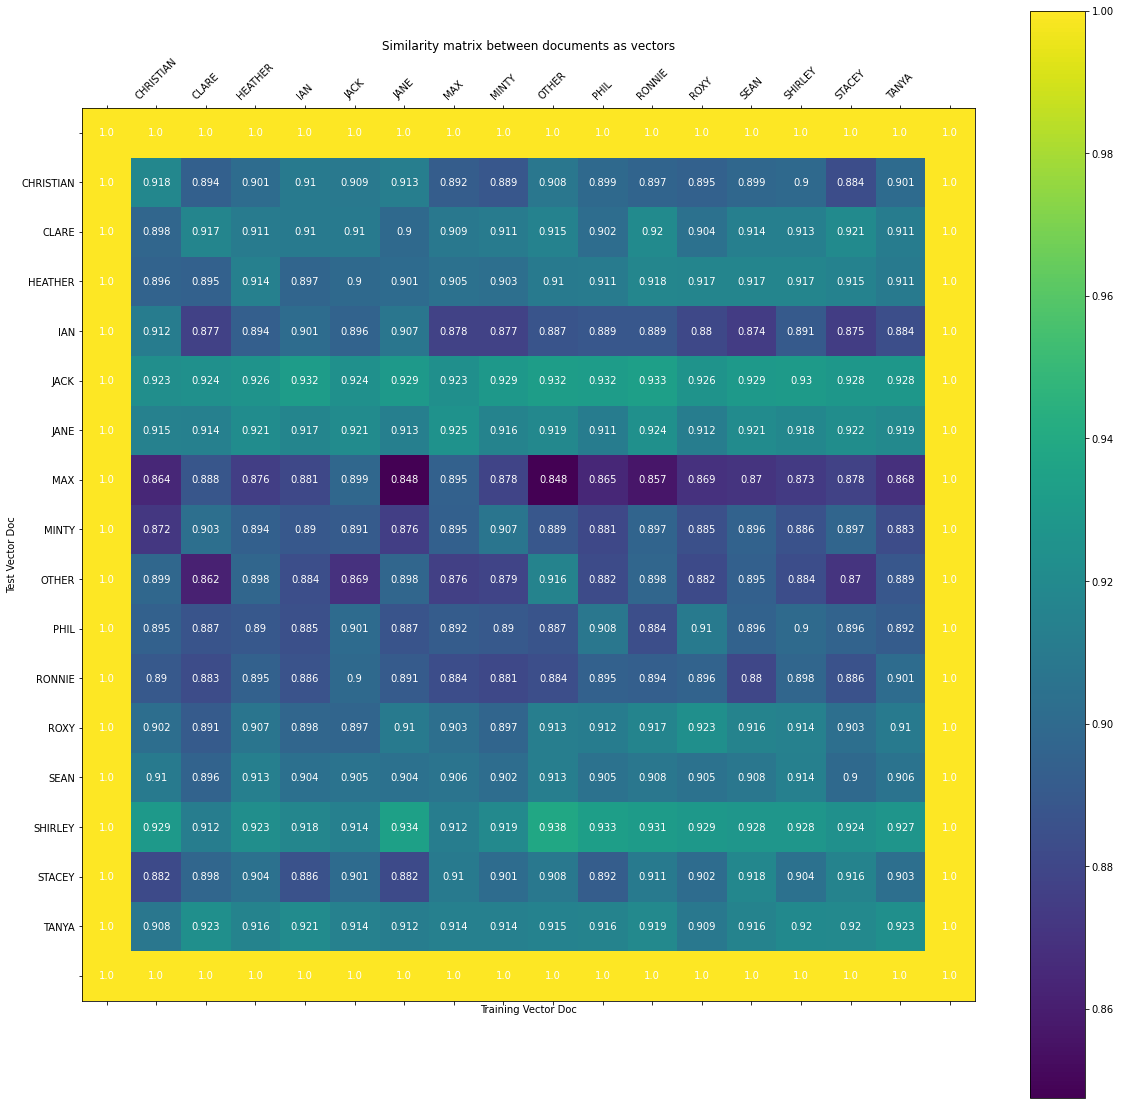

In [20]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (10 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the 90% train and 10% validation data split from the training file, using the first 360 lines from the training split and first 40 lines from the validation split, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **16**. Initially the code in this template achieves a mean rank of **5.12**  and accuracy of **0.3125** on the test set- you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


In [21]:
import contractions
expanded_words = []
def expanded_text(text):    
    for word in text.split():
    # using contractions.fix to expand the shotened words
        expanded_words.append(contractions.fix(word))
    expanded_text = ' '.join(expanded_words)
    return expanded_text
print(expanded_text("you\'re"))


you are


In [22]:
punctuation = ",.!:/?"
def remove_punc(text):
    for punc in punctuation:
        if punc in text:
            text = text.replace(punc, "")
    return text

In [23]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')


def pre_process1(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    # Method 1 : Expand contractions
    # character_text = expanded_text(character_text)

    # Method 2 : Remove single char
    character_text = re.sub(r'\s+[a-zA-Z]\s+', ' ', character_text) 
    character_text = re.sub('[\s]+', ' ', character_text, flags=re.I)
    character_text = re.sub('[\n]+', ' ', character_text)
    character_text = re.sub('[_EOL_]+', ' ', character_text)
    character_text = remove_punc(character_text)


    # Method 3 : Lower/Upper casing 
    # character_text = character_text.upper() 

    tokens = character_text.split()    # just a simple tokenization, to be replaced

    # Method 4 : Remove stopwords
    stop_words = set(stopwords.words('english'))
    stop = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop]


    return tokens

[nltk_data] Downloading package stopwords to /Users/lsc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
training_corpus1 = [(name, pre_process1(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels1 = [name for name, doc in training_corpus]
training_feature_matrix1 = create_document_matrix_from_corpus(training_corpus1, fitting = True)

val_corpus1 = [(name, pre_process1(doc)) for name, doc in val_character_docs.items()]
val_labels1 = [name for name, doc in val_corpus1]
val_feature_matrix1 = create_document_matrix_from_corpus(val_corpus1, fitting=False)


In [25]:
training_corpus1

[('CHRISTIAN',
  ['esley',
   "I'm",
   'really',
   'glad',
   'You',
   'must',
   'Ian',
   'This',
   'partner',
   'Ashley',
   'What',
   'lovely',
   'little',
   'place',
   'So',
   'seen',
   'flesh',
   'Ashley',
   'esley',
   'compare',
   'way',
   'described',
   'keep',
   'forgetting',
   'esley',
   'changed',
   'name',
   'What',
   'would',
   'therapist',
   'bloke',
   'make',
   'He',
   'might',
   'say',
   'indicates',
   'attempt',
   'run',
   'away',
   'somethingBut',
   "let's",
   'go',
   'In',
   'amongst',
   'things',
   'My',
   'sister',
   "what's",
   'called',
   'lovehate',
   'relationship',
   'love',
   'hates',
   '-',
   'right',
   'Jane',
   'And',
   'ove',
   'Very',
   'much',
   'It',
   'breaks',
   'heart',
   'Can',
   'bottle',
   'best',
   'champagne',
   'please',
   'And',
   'start',
   'counting',
   'pennies',
   'Jane',
   "we're",
   'paying',
   "ain't",
   'Ash',
   'You',
   'know',
   'Ian',
   'exactly',
   'imagin

In [26]:
mean_rank1, mean_cosine_simliarity1, acc1, df1 = compute_IR_evaluation_scores(training_feature_matrix1, val_feature_matrix1, train_labels1, val_labels1)

mean rank 1.5
mean cosine similarity 0.5697987649898733
12 correct out of 16 / accuracy: 0.75


## Original result :
mean rank 4.5  
mean cosine similarity 0.9128136458100018  
4 correct out of 16 / accuracy: 0.25

## Method1 result :(Expand constractions)(Abandon)
mean rank 8.375  
mean cosine similarity 0.9999856732793365  
1 correct out of 16 / accuracy: 0.0625

## Method2 result :(Remove single char)
mean rank 2.0625  
mean cosine similarity 0.7892844984523921  
8 correct out of 16 / accuracy: 0.5

## Method3 result :(lower/upper case)(Abandon)
mean rank 4.875  
mean cosine similarity 0.9160879734705301  
6 correct out of 16 / accuracy: 0.375

## Method4 result :(Remove stop words)
mean rank 2.75  
mean cosine similarity 0.9303372526131066  
11 correct out of 16 / accuracy: 0.6875

## Method 2 + 4 result :(Optimum)
mean rank 1.5  
mean cosine similarity 0.5696660054450498  
12 correct out of 16 / accuracy: 0.75

# Q2. Improve linguistic feature extraction (15 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` function above. Examples of extra features could include extracting n-grams of different lengths and including POS-tags. You could also use sentiment analysis and gender classification (using the same data) as additional features.

You could use some feature selection/reduction with techniques like minimum document frequency and/or feature selection like k-best selection using different criteria https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. Again, develop on 90% training and 10% validation split and note the effect/improvement in mean rank with the techniques you use.

In [27]:
from nltk import ngrams
def to_feature_vector_dictionary2(character_doc, extra_features=["ngrams","pos_tags"]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
#     counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    if "ngrams" in extra_features:
        n_grams = []
        n=2
        n_grams.extend([" ".join(x) for x in ngrams(character_doc, n)])
        counts_ngram = Counter(n_grams)
        counts.update(counts_ngram)
    if "pos_tags" in extra_features:
        ptags = []
        for word, ptag in nltk.pos_tag(character_doc):
            ptags.append(word + '_' + ptag)
        counts.update(Counter(ptags))
    return dict(counts)

In [28]:
from nltk import ngrams
def to_feature_vector_dictionary2(character_doc, extra_features=["ngrams","pos_tags"]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
#     counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    if "ngrams" in extra_features:
        n_grams = []
        n=2
        n_grams.extend([" ".join(x) for x in ngrams(character_doc, n)])
        counts_ngram = Counter(n_grams)
        counts.update(counts_ngram)
    if "pos_tags" in extra_features:
        ptags = []
        for word, ptag in nltk.pos_tag(character_doc):
            ptags.append(word + '_' + ptag)
        counts.update(Counter(ptags))
    return dict(counts)

In [29]:
from sklearn.feature_selection import SelectKBest, chi2
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
# corpusVectorizer = TfidfVectorizer(max_df = 0.5, ngram_range = (2,2)) 

def create_document_matrix_from_corpus2(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary2(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary2(doc) for name, doc in corpus])
    KB_matrix = SelectKBest(chi2, k="all").fit_transform(doc_feature_matrix, train_labels2)
    #training_feature_matrix[0].toarray()
    return KB_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [30]:
training_corpus2 = [(name, pre_process1(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels2 = [name for name, doc in training_corpus2]
training_feature_matrix2 = create_document_matrix_from_corpus2(training_corpus2, fitting = True)

val_corpus2 = [(name, pre_process1(doc)) for name, doc in val_character_docs.items()]
val_labels2 = [name for name, doc in val_corpus2]
val_feature_matrix2 = create_document_matrix_from_corpus2(val_corpus2, fitting=False)


In [31]:
print(training_feature_matrix2)

  (0, 49)	26.0
  (0, 51)	2.0
  (0, 63)	1.0
  (0, 80)	1.0
  (0, 82)	1.0
  (0, 85)	2.0
  (0, 99)	1.0
  (0, 109)	1.0
  (0, 121)	1.0
  (0, 124)	1.0
  (0, 130)	2.0
  (0, 138)	1.0
  (0, 147)	1.0
  (0, 164)	1.0
  (0, 189)	1.0
  (0, 193)	1.0
  (0, 206)	1.0
  (0, 208)	1.0
  (0, 216)	1.0
  (0, 222)	1.0
  (0, 226)	1.0
  (0, 234)	1.0
  (0, 237)	1.0
  (0, 238)	1.0
  (0, 263)	26.0
  :	:
  (15, 38734)	4.0
  (15, 38773)	1.0
  (15, 38774)	1.0
  (15, 38775)	1.0
  (15, 38776)	1.0
  (15, 38777)	1.0
  (15, 38778)	1.0
  (15, 38779)	1.0
  (15, 38780)	1.0
  (15, 38781)	1.0
  (15, 38782)	1.0
  (15, 38783)	1.0
  (15, 38784)	1.0
  (15, 38785)	1.0
  (15, 38792)	1.0
  (15, 38795)	1.0
  (15, 38796)	1.0
  (15, 38797)	1.0
  (15, 38798)	1.0
  (15, 38886)	1.0
  (15, 38887)	1.0
  (15, 38888)	1.0
  (15, 38889)	1.0
  (15, 38894)	1.0
  (15, 38898)	1.0


In [32]:
mean_rank2, mean_cosine_simliarity2, acc2, df2 = compute_IR_evaluation_scores(training_feature_matrix2, val_feature_matrix2, train_labels2, val_labels2)

mean rank 1.4375
mean cosine similarity 0.5124748973274369
12 correct out of 16 / accuracy: 0.75


## continue with Q1 result:
mean rank 1.5  
mean cosine similarity 0.5696660054450498  
12 correct out of 16 / accuracy: 0.75

## ngram result:(n=2)
mean rank 1.4375  
mean cosine similarity 0.5014189830522802  
13 correct out of 16 / accuracy: 0.8125 

## ngram result:(n=3)
mean rank 1.4375  
mean cosine similarity 0.5295032810983387  
13 correct out of 16 / accuracy: 0.8125  

## Post tag result:
mean rank 1.375  
mean cosine similarity 0.550476379989453  
13 correct out of 16 / accuracy: 0.8125  

## Post tag + ngram(n=2):(Optimum)
mean rank 1.375  
mean cosine similarity 0.550476379989453  
13 correct out of 16 / accuracy: 0.8125



## 

## K-Best selection:
mean rank 1.375  
mean cosine similarity 0.550476379989453  
13 correct out of 16 / accuracy: 0.8125

# Q3. Add dialogue context data and features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (immediately before and after). You can also use **scene information** from the other columns **(but NOT the gender and character names directly)**.

In [33]:
train_data.keys

<bound method NDFrame.keys of        Episode  Scene                   Scene_info Character_name  \
0         1350      1  DESERTED CAR PARK EXT NIGHT        SHIRLEY   
1         1350      1  DESERTED CAR PARK EXT NIGHT          OTHER   
2         1350      2                R&R INT NIGHT           JACK   
3         1350      2                R&R INT NIGHT         RONNIE   
4         1350      2                R&R INT NIGHT           JACK   
...        ...    ...                          ...            ...   
15314     1399     55         SQUARE EXT DAY LIGHT          OTHER   
15315     1399     55         SQUARE EXT DAY LIGHT            MAX   
15316     1399     55         SQUARE EXT DAY LIGHT          OTHER   
15317     1399     55         SQUARE EXT DAY LIGHT            MAX   
15318     1399     55         SQUARE EXT DAY LIGHT          OTHER   

                                                                                                              Line  \
0                      

In [34]:
# Create one document per character
def create_character_document_from_dataframe3(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    new_dict = {}
    character_docs = {}
    character_line_count = {}
    # episode_scene : line
    for line, episode_scene in zip(df.Line, df.episode_scene):
        if episode_scene not in new_dict:
            new_dict[episode_scene] = []
        new_dict[episode_scene].append(str(line))

    for line, name, episode_scene in zip(df.Line, df.Character_name, df.episode_scene):
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name]==max_line_count:
            continue
        try:
            curr_index = new_dict[episode_scene].index(line)
        except:
            continue
        # Adding PRE token
        if curr_index - 1 >= 0:
            character_docs[name] += "_PRE_" + new_dict[episode_scene][curr_index-1]

        # Adding AFTER token
        if curr_index + 1 < len(new_dict[episode_scene]):
            character_docs[name] += "_AFTER_" + new_dict[episode_scene][curr_index+1]
            
        character_docs[name] += " _EOL_ "  # adding an end-of-line token
        character_line_count[name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [35]:
from nltk import ngrams
def to_feature_vector_dictionary3(character_doc, extra_features=["ngrams","pos_tags"]):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
#     counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    if "ngrams" in extra_features:
        n_grams = []
        n=2
        n_grams.extend([" ".join(x) for x in ngrams(character_doc, n)])
        counts_ngram = Counter(n_grams)
        counts.update(counts_ngram)
    if "pos_tags" in extra_features:
        ptags = []
        for word, ptag in nltk.pos_tag(character_doc):
            ptags.append(word + '_' + ptag)
        counts.update(Counter(ptags))
    return dict(counts)

In [36]:
from sklearn.feature_selection import SelectKBest, chi2
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
# corpusVectorizer = TfidfVectorizer(max_df = 0.5, ngram_range = (2,2)) 

def create_document_matrix_from_corpus3(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary3(doc) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary3(doc) for name, doc in corpus])
    KB_matrix = SelectKBest(chi2, k="all").fit_transform(doc_feature_matrix, train_labels2)
    #training_feature_matrix[0].toarray()
    return KB_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [37]:
train_character_docs3= create_character_document_from_dataframe3(train_data, 360)
training_corpus3 = [(name, pre_process1(doc)) for name, doc in train_character_docs3.items()]
train_labels3 = [name for name, doc in training_corpus3]
training_feature_matrix3 = create_document_matrix_from_corpus2(training_corpus3, fitting=True)

val_character_docs3= create_character_document_from_dataframe3(val_data, 40)
val_corpus3 = [(name, pre_process1(doc)) for name, doc in val_character_docs3.items()]
val_labels3 = [name for name, doc in val_corpus3]
val_feature_matrix3 = create_document_matrix_from_corpus2(val_corpus3, fitting=False)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}


In [38]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix3, val_feature_matrix3, train_labels3, val_labels3)

mean rank 2.375
mean cosine similarity 0.9233668914704828
10 correct out of 16 / accuracy: 0.625


## result based on Q2:
mean rank 1.375  
mean cosine similarity 0.550476379989453  
13 correct out of 16 / accuracy: 0.8125
## adding context to feature:
mean rank 2.375  
mean cosine similarity 0.9233662847330084  
10 correct out of 16 / accuracy: 0.625

## adding context to feature removing POS tag:
mean rank 2.375  
mean cosine similarity 0.923364904292963  
10 correct out of 16 / accuracy: 0.625


# Q4. Improve the vectorization method (10 marks)
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

In [40]:
training_corpus[1]

('CLARE',
 ['Dot?',
  'Dot!',
  '_EOL_',
  "Where's",
  'Dot?',
  '_EOL_',
  'Do',
  'people',
  'still',
  'use',
  'this',
  'place?',
  '_EOL_',
  'And',
  'what',
  'about',
  'Pauline?',
  '_EOL_',
  'Something',
  'like',
  'that.',
  '_EOL_',
  'I',
  "didn't.",
  '_EOL_',
  "I'm",
  'waiting',
  'for',
  'someone.',
  '_EOL_',
  'The',
  'fella',
  'that',
  'runs',
  'this',
  'place.',
  'Does',
  'he',
  'still',
  'live',
  'round',
  'here?',
  '_EOL_',
  'Bit',
  'of',
  'a',
  'comedown',
  'from',
  'the',
  'one',
  'I',
  'remember.',
  '_EOL_',
  'Bacon',
  'sandwich.',
  'Please.',
  '_EOL_',
  'Not',
  'really.',
  '_EOL_',
  'Listen...er...',
  '_EOL_',
  'I',
  "don't",
  'suppose',
  'you',
  'could',
  'lend',
  'me',
  'some',
  'cash',
  'can',
  'ya?',
  'Just',
  'to',
  'get',
  'me',
  'out',
  'of',
  'here.',
  '_EOL_',
  'Pauline...',
  '_EOL_',
  'Come',
  'on,',
  'Ian.',
  'You',
  'chucked',
  'me',
  'and',
  'Sonia',
  'out',
  'the',
  'cafe',
 

In [41]:
# Convert dict
def convert_dict_string(dict):
        new_dict = []
        for key,value in dict.items():
            new_dict.extend([key]*value)
        new_dict = ' '.join(new_dict)
        return new_dict
    

In [42]:
# corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
from sklearn.feature_extraction.text import TfidfVectorizer
corpusVectorizer = TfidfVectorizer(max_df = 0.5, ngram_range = (2,2)) 

def create_document_matrix_from_corpus4(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things

    # if fitting:
        # corpusVectorizer.fit([to_feature_vector_dictionary2(doc) for name, doc in corpus])
    if fitting:
        corpusVectorizer.fit([convert_dict_string(to_feature_vector_dictionary2(doc)) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([convert_dict_string(to_feature_vector_dictionary2(doc)) for name, doc in corpus])
   
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus4(training_corpus, fitting=True)

In [43]:
train_character_docs4= create_character_document_from_dataframe(train_data, 360)
training_corpus4 = [(name, pre_process1(doc)) for name, doc in train_character_docs4.items()]
train_labels4 = [name for name, doc in training_corpus4]
training_feature_matrix4 = create_document_matrix_from_corpus4(training_corpus4, fitting=True)

val_character_docs4= create_character_document_from_dataframe(val_data, 40)
val_corpus4 = [(name, pre_process1(doc)) for name, doc in val_character_docs4.items()]
val_labels4 = [name for name, doc in val_corpus4]
val_feature_matrix4 = create_document_matrix_from_corpus4(val_corpus4, fitting=False)

lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY': 40, 'HEATHER': 40, 'MINTY': 40, 'CHRISTIAN': 40, 'CLARE': 40}


In [44]:
mean_rank4, mean_cosine_simliarity4, acc4, df4 = compute_IR_evaluation_scores(training_feature_matrix4, val_feature_matrix4, train_labels4, val_labels4)

mean rank 1.375
mean cosine similarity 0.14871216337335158
12 correct out of 16 / accuracy: 0.75


## TF-IDF :
mean rank 1.375  
mean cosine similarity 0.14871216337335158  
12 correct out of 16 / accuracy: 0.75

# Q5. Select and test the best vector representation method (10 marks)
Finish the optimization of your vector representations by selecting the best combination of the techniques you tried in Q1-3 and test using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [50]:
using_context = False
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe3(all_train_data, max_line_count=400)
if using_context:
    train_character_docs = create_character_document_from_dataframe3(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process1(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

tfidfCorpusVectorizer = TfidfVectorizer(max_df = 0.5, ngram_range = (2,2)) 

training_feature_matrix = create_document_matrix_from_corpus4(training_corpus, fitting=True)
epsiode_scene_column_test = test_data.Episode.astype(str) + "-" + test_data.Scene.astype(str)
test_data["episode_scene"] = epsiode_scene_column_test
# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe3(test_data, max_line_count=40)
if using_context:
    test_character_docs = create_character_document_from_dataframe3(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process1(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus4(test_corpus, fitting=False)




lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  6926
OTHER Number of Words:  5328
JACK Number of Words:  6365
RONNIE Number of Words:  7631
TANYA Number of Words:  6424
SEAN Number of Words:  6884
ROXY Number of Words:  7082
HEATHER Number of Words:  7385
MAX Number of Words:  6644
IAN Number of Words:  7134
JANE Number of Words:  7198
STACEY Number of Words:  7114
PHIL Number of Words:  8067
MINTY Number of Words:  7885
CHRISTIAN Number of Words:  6760
CLARE Number of Words:  7061
total words 111888
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}
Num. Characters: 

In [51]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

mean rank 1.25
mean cosine similarity 0.1388765048677307
13 correct out of 16 / accuracy: 0.8125


/var/folders/c6/nl5vbwj11txcp5fr77ff8rmw0000gn/T/ipykernel_11885/932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:


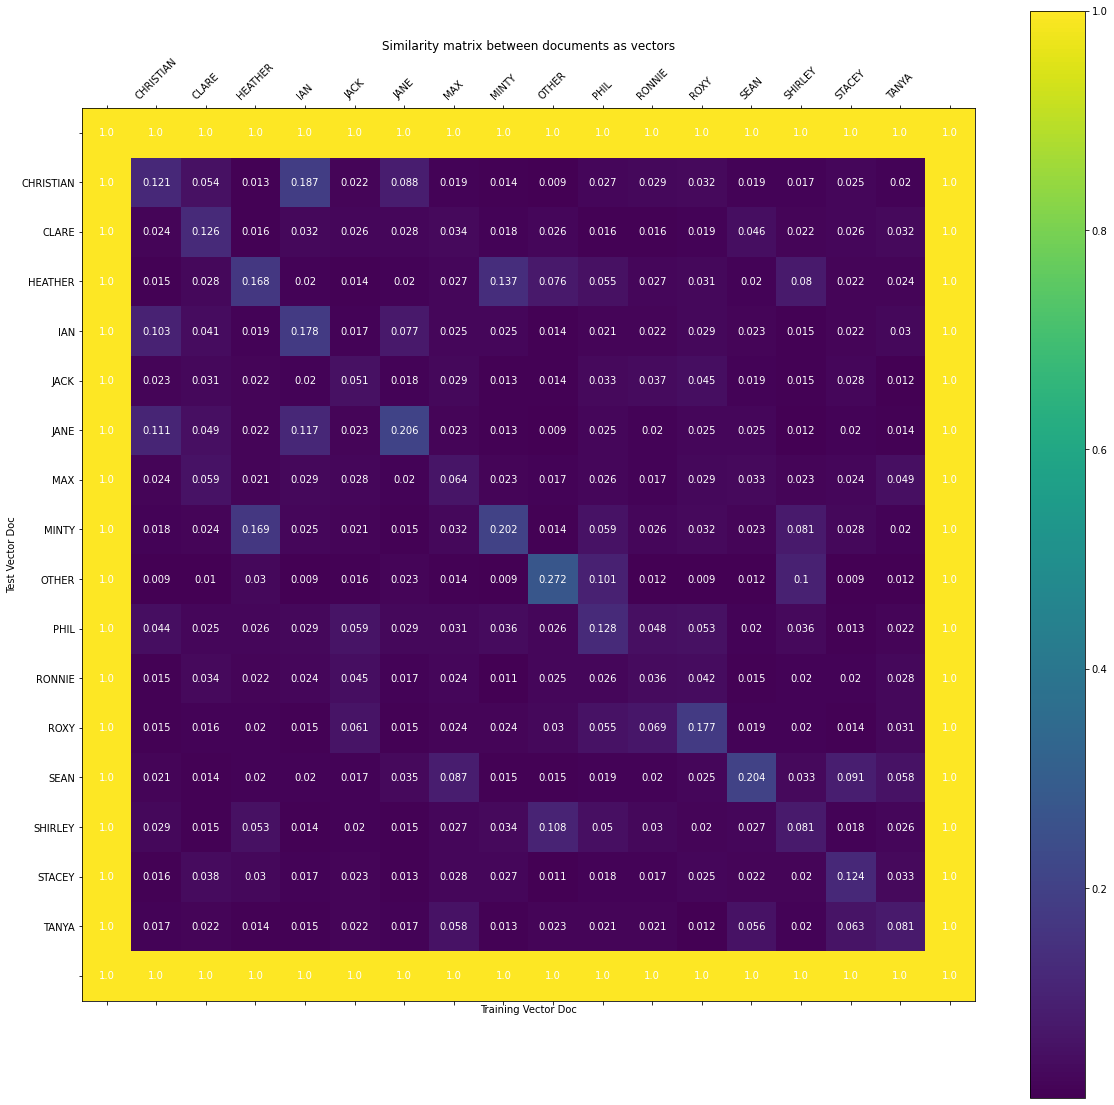

In [52]:
plot_heat_map_similarity(df)

## Final result:
mean rank 1.25  
mean cosine similarity 0.1388765048677307  
13 correct out of 16 / accuracy: 0.8125